In [1]:
from Bio.PDB import PDBParser
import numpy as np
import gudhi
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from Bio.PDB.MMCIFParser import MMCIFParser

In [2]:
def create_df(structure):
    '''creates python data frame of data from .pdb files of 3D protein structures'''
    structure_list = []
    for model in structure: 
        for chain in model:
            for residue in chain:
                for atom in residue:
                    atom_info = {
                        "Model": model.id,
                        "Chain": chain.id,
                        "Residue_Name": residue.get_resname(),
                        "Residue_ID": residue.get_id()[1],  # Sequence number
                        "Atom_Name": atom.get_name(),
                        "Element": atom.element,
                        "X": atom.coord[0],
                        "Y": atom.coord[1],
                        "Z": atom.coord[2]
                    }
                    structure_list.append(atom_info)
    df = pd.DataFrame(structure_list)
    return df

In [3]:
# Bottleneck Distances
def bottleneck_distances(d1, d2, p=False, d1_name="", d2_name=""):
    distances = []
    for i in range(3):
        d1_pairs = np.array([pair for dim, pair in d1 if dim == i])
        d2_pairs = np.array([pair for dim, pair in d2 if dim == i])
        # get rid of inf values
        d1_noinf = d1_pairs[~np.isinf(d1_pairs).any(axis=1)]
        d2_noinf = d2_pairs[~np.isinf(d2_pairs).any(axis=1)]
        distances.append(gudhi.bottleneck_distance(d1_noinf, d2_noinf))
    if p == True:
        print(f"Bottleneck distances between {d1_name} and {d2_name}:")
        for i in range(3):
            print(f"\tDimension {i}:", distances[i])
    return distances

In [4]:
parser1 = PDBParser(QUIET=True)
sicklecell = parser1.get_structure("sicklecell", "data/5e83.pdb")
sicklecell_df = create_df(sicklecell)

parser2 = PDBParser(QUIET=True)
deoxy = parser2.get_structure("deoxy", "data/1a3n.pdb") # deoxy
deoxy_df = create_df(deoxy)

parser3 = MMCIFParser(QUIET=True)
oxy = parser3.get_structure("oxy1", "data/1hho-assembly1.cif")
oxy_df = create_df(oxy)

In [5]:
# oxy vs deoxy
oxy1_df = oxy_df[oxy_df["Residue_Name"] != "OXY"] # remove oxygens from point cloud
oxy_point_cloud = oxy_df[['X', 'Y', 'Z']].to_numpy()
oxy_rips_complex = gudhi.RipsComplex(points=oxy_point_cloud, max_edge_length=8.0) 
oxy_simplex_tree = oxy_rips_complex.create_simplex_tree(max_dimension=3)
oxy_diagram = oxy_simplex_tree.persistence(min_persistence=0.5)

deoxy_point_cloud = deoxy_df[['X', 'Y', 'Z']].to_numpy()
deoxy_rips_complex = gudhi.RipsComplex(points=deoxy_point_cloud, max_edge_length=8.0)  
deoxy_simplex_tree = deoxy_rips_complex.create_simplex_tree(max_dimension=3)
deoxy_diagram = deoxy_simplex_tree.persistence(min_persistence=0.5)

bottleneck_sickle_deoxy = bottleneck_distances(deoxy_diagram, oxy_diagram, p=True, d1_name="deoxy hemoglobin", d2_name="oxygenated hemoglobin")

Bottleneck distances between deoxy hemoglobin and oxygenated hemoglobin:
	Dimension 0: 1.1514849480036637
	Dimension 1: 1.3829076665140612
	Dimension 2: 0.6686509901140765


In [10]:
from gudhi import AlphaComplex

alpha_complex = AlphaComplex(points=oxy_point_cloud)
simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=64.0)
diagram = simplex_tree.persistence(min_persistence=0.5)


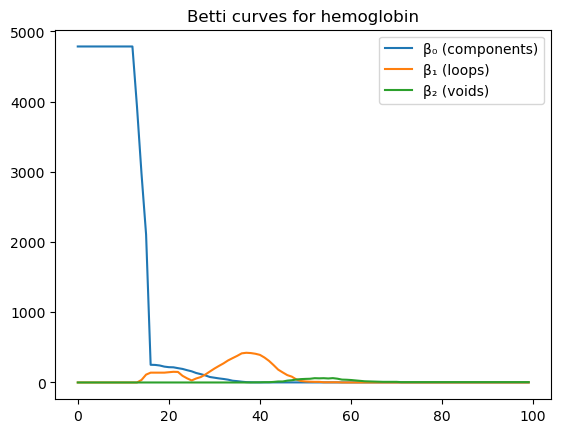

In [11]:
import numpy as np
import matplotlib.pyplot as plt

betti_numbers = np.zeros((3, 100))  # dim 0, 1, 2

for i in range(len(oxy_diagram)):
    dim, (birth, death) = oxy_diagram[i]
    for j in range(100):
        t = j * 0.1
        if birth <= t <= death:
            betti_numbers[dim, j] += 1

plt.plot(betti_numbers[0], label="β₀ (components)")
plt.plot(betti_numbers[1], label="β₁ (loops)")
plt.plot(betti_numbers[2], label="β₂ (voids)")
plt.legend()
plt.title("Betti curves for hemoglobin")
plt.show()


In [9]:
oxy_simplex_tree.compute_persistence()
generators = oxy_simplex_tree.persistence_generators()
for dim, cycle in generators:
    if dim == 2:
        for simplex in cycle:
            if len(simplex) == 2:  # an edge
                i, j = simplex
                p1 = oxy_point_cloud[i]
                p2 = oxy_point_cloud[j]
            print(f"Edge from {p1} to {p2}")



AttributeError: 'gudhi.simplex_tree.SimplexTree' object has no attribute 'persistence_generators'

In [18]:
sicklecell_df#["Residue_Name"].unique()

,Model,Chain,Residue_Name,Residue_ID,Atom_Name,Element,X,Y,Z
0,0,A,VAL,1,N,N,24.471001,15.116000,21.799000
1,0,A,VAL,1,CA,C,25.270000,16.358000,21.725000
2,0,A,VAL,1,C,C,24.497999,17.414000,22.497999
3,0,A,VAL,1,O,O,23.374001,17.757000,22.128000
4,0,A,VAL,1,CB,C,25.504000,16.834999,20.275999
...,...,...,...,...,...,...,...,...,...
5005,0,D,HOH,400,O,O,13.584000,-3.939000,30.999001
5006,0,D,HOH,401,O,O,12.247000,-6.189000,14.528000
5007,0,D,HOH,402,O,O,13.227000,-11.289000,-5.660000
5008,0,D,HOH,403,O,O,34.868999,-13.890000,9.907000
